In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, make_scorer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Data Loading and Preprocessing
# -----------------------------------------------------------------------------------

In [11]:
cdc_heart_df = pd.read_csv("heart_2022_no_nans.csv")
cdc_heart_df['HadHeartAttack'] = cdc_heart_df['HadHeartAttack'].apply(lambda x: 1 if x == 'Yes' else 0)
X = cdc_heart_df.drop(columns=['HadHeartAttack'])
y = cdc_heart_df['HadHeartAttack']
X, _, y, _ = train_test_split(X, y, test_size=0.95, stratify=y, random_state=42)
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64']).columns

In [13]:
cdc_heart_df.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,0,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,0,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",0,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,0,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,0,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [15]:
cdc_heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246022 entries, 0 to 246021
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      246022 non-null  object 
 1   Sex                        246022 non-null  object 
 2   GeneralHealth              246022 non-null  object 
 3   PhysicalHealthDays         246022 non-null  float64
 4   MentalHealthDays           246022 non-null  float64
 5   LastCheckupTime            246022 non-null  object 
 6   PhysicalActivities         246022 non-null  object 
 7   SleepHours                 246022 non-null  float64
 8   RemovedTeeth               246022 non-null  object 
 9   HadHeartAttack             246022 non-null  int64  
 10  HadAngina                  246022 non-null  object 
 11  HadStroke                  246022 non-null  object 
 12  HadAsthma                  246022 non-null  object 
 13  HadSkinCancer              24

C:\Users\cedga\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


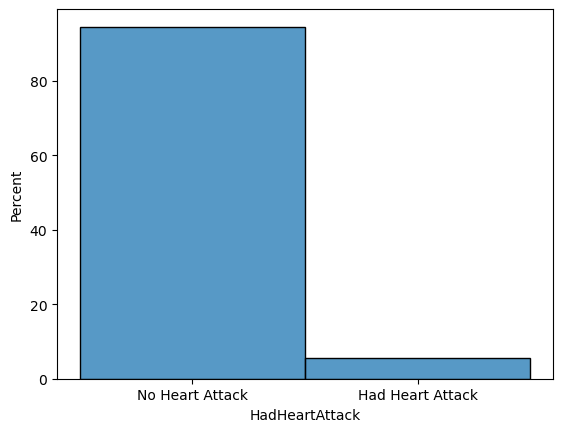

In [32]:
sns.histplot(data=cdc_heart_df, x="HadHeartAttack", stat="percent", discrete=True)

# Set the x-axis labels to the category names
plt.xticks([0, 1], ['No Heart Attack', 'Had Heart Attack'])

# Show the plot
plt.show()

In [34]:
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols), ('cat', categorical_transformer, categorical_cols)])

In [36]:
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.25, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

# Training Baseline Models
# -----------------------------------------------------------------------------------

In [42]:
# Train baseline RFC model on original data
baseline_model_RFC = RandomForestClassifier(random_state=42)
baseline_model_RFC.fit(X_train_transformed, y_train)
baseline_y_pred = baseline_model_RFC.predict(X_test_transformed)
print("Baseline RFC model performance:")
print(classification_report(y_test, baseline_y_pred))

Baseline model performance:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2334
           1       0.39      0.06      0.10       127

    accuracy                           0.95      2461
   macro avg       0.67      0.53      0.53      2461
weighted avg       0.92      0.95      0.93      2461



In [47]:
# Train baseline GBM model on original data
baseline_model_gbm = GradientBoostingClassifier(random_state=42)
baseline_model_gbm.fit(X_train_transformed, y_train)
baseline_y_pred = baseline_model_gbm.predict(X_test_transformed)
print("Baseline GBM model performance:")
print(classification_report(y_test, baseline_y_pred))

Baseline model performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2334
           1       0.50      0.24      0.32       127

    accuracy                           0.95      2461
   macro avg       0.73      0.61      0.65      2461
weighted avg       0.94      0.95      0.94      2461



In [59]:
# Train baseline XGB model on original data
baseline_model_xgb = XGBClassifier(random_state=42)
baseline_model_xgb.fit(X_train_transformed, y_train)
baseline_y_pred = baseline_model_xgb.predict(X_test_transformed)
print("Baseline XGB model performance:")
print(classification_report(y_test, baseline_y_pred))

Baseline XGB model performance:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      2334
           1       0.43      0.20      0.27       127

    accuracy                           0.95      2461
   macro avg       0.69      0.59      0.62      2461
weighted avg       0.93      0.95      0.94      2461



In [55]:
# Define the number of folds for cross-validation
cv_folds = 5

In [57]:
# RandomForest Classifier
baseline_model_RFC = RandomForestClassifier(random_state=42)
rfc_cv_scores = cross_val_score(baseline_model_RFC, X_train_transformed, y_train, cv=cv_folds, scoring='recall')
print(f"RandomForest CV Recall Scores: {rfc_cv_scores}")
print(f"RandomForest Mean Recall: {rfc_cv_scores.mean()}")

# GradientBoosting Classifier
baseline_model_gbm = GradientBoostingClassifier(random_state=42)
gbm_cv_scores = cross_val_score(baseline_model_gbm, X_train_transformed, y_train, cv=cv_folds, scoring='recall')
print(f"GradientBoosting CV Recall Scores: {gbm_cv_scores}")
print(f"GradientBoosting Mean Recall: {gbm_cv_scores.mean()}")

# XGBoost Classifier
baseline_model_xgb = XGBClassifier(random_state=42)
xgb_cv_scores = cross_val_score(baseline_model_xgb, X_train_transformed, y_train, cv=cv_folds, scoring='recall')
print(f"XGBoost CV Recall Scores: {xgb_cv_scores}")
print(f"XGBoost Mean Recall: {xgb_cv_scores.mean()}")

RandomForest CV Recall Scores: [0.07317073 0.1097561  0.09638554 0.07228916 0.08433735]
RandomForest Mean Recall: 0.08718777549221277
GradientBoosting CV Recall Scores: [0.24390244 0.20731707 0.19277108 0.18072289 0.14457831]
GradientBoosting Mean Recall: 0.1938583602703497
XGBoost CV Recall Scores: [0.18292683 0.2195122  0.1686747  0.24096386 0.13253012]
XGBoost Mean Recall: 0.18892153981780782


# Feature Selection with RFECV
# -----------------------------------------------------------------------------------

### 1. Applying RFECV to Gradient Boosting Machine (GBM):

In [65]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier

# Create a GBM model for RFECV
gbm_model = GradientBoostingClassifier(random_state=42)

# Apply RFECV for feature selection
rfecv_gbm = RFECV(estimator=gbm_model, step=1, cv=5, scoring='recall')
rfecv_gbm.fit(X_train_transformed, y_train)

# Transform the datasets to include only the selected features
X_train_selected_gbm = rfecv_gbm.transform(X_train_transformed)
X_val_selected_gbm = rfecv_gbm.transform(X_val_transformed)
X_test_selected_gbm = rfecv_gbm.transform(X_test_transformed)

# Check the number of selected features
print("Optimal number of features selected by GBM:", rfecv_gbm.n_features_)

Optimal number of features selected by GBM: 27


In [68]:
# Check the number of features selected and which features they are
print("Optimal number of features:", rfecv_gbm.n_features_)
print("Best features mask:", rfecv_gbm.support_)

Optimal number of features: 27
Best features mask: [ True  True  True  True  True  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False  True False  True False False False False False False False False
 False False  True  True  True  True  True  True  True False False False
 False  True False False False  True False False  True  True False False
 False  True False False False False False  True False False False False
 False False  True False False False False False False False  True False
 False False False False False False False False False False False False
 False False False  True  True False False False False False False False
 False False False False False False False False False False]


### 2. Applying RFECV to XGBoost:

In [70]:
# Create an XGBoost model for RFECV
xgb_model = XGBClassifier(random_state=42)

# Apply RFECV for feature selection
rfecv_xgb = RFECV(estimator=xgb_model, step=1, cv=5, scoring='recall')
rfecv_xgb.fit(X_train_transformed, y_train)

# Transform the datasets to include only the selected features
X_train_selected_xgb = rfecv_xgb.transform(X_train_transformed)
X_val_selected_xgb = rfecv_xgb.transform(X_val_transformed)
X_test_selected_xgb = rfecv_xgb.transform(X_test_transformed) 

# Check the number of selected features
print("Optimal number of features selected by XGBoost:", rfecv_xgb.n_features_)

Optimal number of features selected by XGBoost: 26


# Resampling Techniques
# -----------------------------------------------------------------------------------

In [72]:
# Define the resampling techniques
resamplers = {
    'SMOTE': SMOTE(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

In [74]:
# Loop through each resampling technique and apply it to the selected features
for name, resampler in resamplers.items():
    print(f"Applying {name} to GBM...")
    
    # Resample the training data
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_selected_gbm, y_train)
    
    # Train the GBM model on the resampled data
    gbm_model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model on the test set
    y_pred = gbm_model.predict(X_test_selected_gbm)
    
    # Print the classification report
    print(f"{name} GBM Model Performance:")
    print(classification_report(y_test, y_pred))

Applying SMOTE to GBM...
SMOTE GBM Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2334
           1       0.42      0.37      0.39       127

    accuracy                           0.94      2461
   macro avg       0.69      0.67      0.68      2461
weighted avg       0.94      0.94      0.94      2461

Applying SMOTEENN to GBM...
SMOTEENN GBM Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2334
           1       0.33      0.58      0.42       127

    accuracy                           0.92      2461
   macro avg       0.65      0.76      0.69      2461
weighted avg       0.94      0.92      0.93      2461

Applying SMOTETomek to GBM...
SMOTETomek GBM Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2334
           1       0.42      0.36      0.39       127

    

In [76]:
# Loop through each resampling technique and apply it to the selected features
for name, resampler in resamplers.items():
    print(f"Applying {name} to XGBoost...")
    
    # Resample the training data
    X_train_resampled, y_train_resampled = resampler.fit_resample(X_train_selected_xgb, y_train)
    
    # Train the XGBoost model on the resampled data
    xgb_model.fit(X_train_resampled, y_train_resampled)
    
    # Evaluate the model on the test set
    y_pred = xgb_model.predict(X_test_selected_xgb)
    
    # Print the classification report
    print(f"{name} XGBoost Model Performance:")
    print(classification_report(y_test, y_pred))

Applying SMOTE to XGBoost...
SMOTE XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2334
           1       0.42      0.23      0.30       127

    accuracy                           0.94      2461
   macro avg       0.69      0.61      0.63      2461
weighted avg       0.93      0.94      0.94      2461

Applying SMOTEENN to XGBoost...
SMOTEENN XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      2334
           1       0.31      0.48      0.38       127

    accuracy                           0.92      2461
   macro avg       0.64      0.71      0.67      2461
weighted avg       0.94      0.92      0.93      2461

Applying SMOTETomek to XGBoost...
SMOTETomek XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2334
           1       0.42      0.23  

# Hyperparameter Tuning with GridSearchCV
# -----------------------------------------------------------------------------------

In [86]:
# Define the parameter grid for Gradient Boosting
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [88]:
# Create the GBM model
gbm_model = GradientBoostingClassifier(random_state=42)

# Create the SMOTEENN resampler
smote_enn = SMOTEENN(random_state=42)

# Create a pipeline with SMOTEENN and GBM
pipeline = ImbPipeline(steps=[
    ('resampler', smote_enn),
    ('classifier', gbm_model)
])

In [90]:
# Set up GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)

# Fit the model with GridSearchCV
grid_search.fit(X_train_selected_gbm, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


In [94]:
print("Best Hyperparameters:", best_params)
print("Best Recall Score from GridSearchCV:", best_score)

Best Hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best Recall Score from GridSearchCV: 0.760417278871584


# Implementing Final Model
# -----------------------------------------------------------------------------------

In [98]:
# Train the final model with the best hyperparameters
final_gbm_model = GradientBoostingClassifier(
    learning_rate=best_params['classifier__learning_rate'],
    max_depth=best_params['classifier__max_depth'],
    min_samples_leaf=best_params['classifier__min_samples_leaf'],
    min_samples_split=best_params['classifier__min_samples_split'],
    n_estimators=best_params['classifier__n_estimators'],
    subsample=best_params['classifier__subsample'],
    random_state=42
)

In [100]:
# Integrate the resampler and model into a pipeline
final_pipeline = ImbPipeline(steps=[
    ('resampler', SMOTEENN(random_state=42)),
    ('classifier', final_gbm_model)
])

In [102]:
# Fit the final model to the full training set
final_pipeline.fit(X_train_selected_gbm, y_train)

Pipeline(steps=[('resampler', SMOTEENN(random_state=42)),
                ('classifier',
                 GradientBoostingClassifier(learning_rate=0.01, random_state=42,
                                            subsample=0.8))])

In [104]:
# Predict on the test set
y_pred_final = final_pipeline.predict(X_test_selected_gbm)

# Evaluate the final model's performance
print("Final Model Performance on Test Set:")
print(classification_report(y_test, y_pred_final))

Final Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      2334
           1       0.14      0.75      0.24       127

    accuracy                           0.76      2461
   macro avg       0.56      0.75      0.55      2461
weighted avg       0.94      0.76      0.82      2461



# Model Calibration
# -----------------------------------------------------------------------------------

In [108]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score

C:\Users\cedga\anaconda3\Lib\site-packages\sklearn\calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Calibrated Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      2334
           1       0.00      0.00      0.00       127

    accuracy                           0.95      2461
   macro avg       0.47      0.50      0.49      2461
weighted avg       0.90      0.95      0.92      2461

AUC of Calibrated Model: 0.861415298666073


C:\Users\cedga\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cedga\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cedga\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


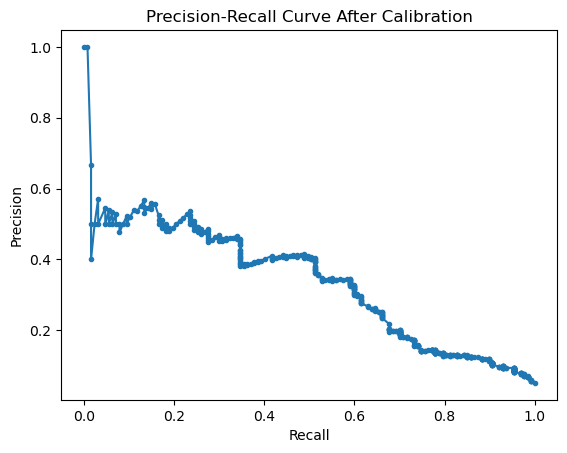

In [110]:
# Assuming final_pipeline is your trained pipeline with the best GBM model and SMOTEENN

# Step 1: Apply calibration using CalibratedClassifierCV
calibrator = CalibratedClassifierCV(base_estimator=final_pipeline, method='sigmoid', cv=5)  # You can also try method='isotonic'
calibrator.fit(X_train_selected_gbm, y_train)

# Step 2: Predict on the test set using the calibrated model
y_pred_calibrated = calibrator.predict(X_test_selected_gbm)

# Step 3: Evaluate the calibrated model's performance
print("Calibrated Model Performance on Test Set:")
print(classification_report(y_test, y_pred_calibrated))

# Step 4: Evaluate the calibrated probabilities (optional, for understanding calibration effects)
y_prob_calibrated = calibrator.predict_proba(X_test_selected_gbm)[:, 1]

# Check AUC as a measure of the quality of the probability predictions
roc_auc = roc_auc_score(y_test, y_prob_calibrated)
print(f"AUC of Calibrated Model: {roc_auc}")

# Step 5: Plot precision-recall curve for the calibrated model
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_calibrated)

# Plot Precision-Recall curve
import matplotlib.pyplot as plt

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve After Calibration')
plt.show()

In [147]:
# Step 6: Adjust the decision threshold
threshold = 0.05  # Example threshold, adjust based on the precision-recall curve or other criteria
y_pred_adjusted = (y_prob_calibrated >= threshold).astype(int)

# Step 7: Evaluate the model with the adjusted threshold
print("Model Performance with Adjusted Threshold:")
print(classification_report(y_test, y_pred_adjusted))

Model Performance with Adjusted Threshold:
              precision    recall  f1-score   support

           0       0.98      0.76      0.85      2334
           1       0.14      0.75      0.24       127

    accuracy                           0.76      2461
   macro avg       0.56      0.75      0.55      2461
weighted avg       0.94      0.76      0.82      2461



In [149]:
# Step 1: Extract probabilities using the calibrated model
# Note: `y_prob_calibrated` contains the probabilities from the previous calibration step
X_test['probability'] = y_prob_calibrated  # Add the calibrated probabilities to the test dataset

In [151]:
# Step 2: Calculate the average probability of having a heart attack by state
# Assuming `X_test` has a 'State' column that indicates the state for each observation
state_probabilities = X_test.groupby('State')['probability'].mean().reset_index()

In [153]:
# Sort the states by the average probability
state_probabilities.sort_values(by='probability', ascending=False, inplace=True)


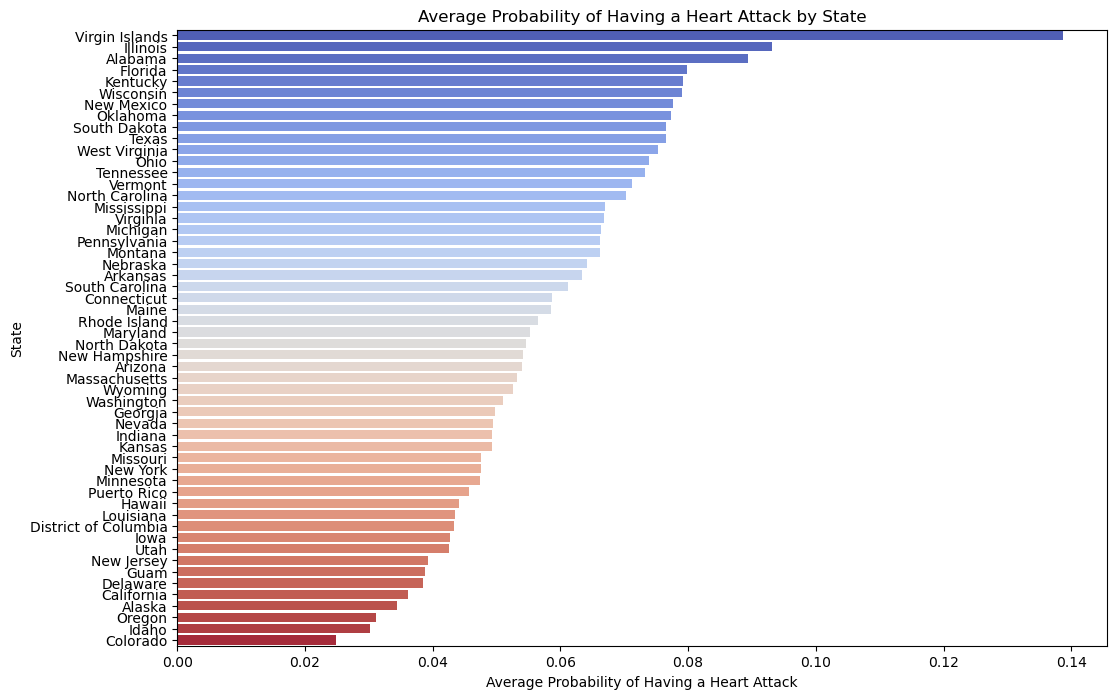

In [155]:
# Step 3: Plot the average probabilities by state
plt.figure(figsize=(12, 8))
sns.barplot(x='probability', y='State', data=state_probabilities, palette='coolwarm')
plt.xlabel('Average Probability of Having a Heart Attack')
plt.ylabel('State')
plt.title('Average Probability of Having a Heart Attack by State')
plt.show()

In [157]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [243]:
# Load the shapefile
gdf = gpd.read_file("cb_2018_us_state_500k.shp")

gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21524, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00256 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


In [245]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     object  
 1   STATENS   56 non-null     object  
 2   AFFGEOID  56 non-null     object  
 3   GEOID     56 non-null     object  
 4   STUSPS    56 non-null     object  
 5   NAME      56 non-null     object  
 6   LSAD      56 non-null     object  
 7   ALAND     56 non-null     int64   
 8   AWATER    56 non-null     int64   
 9   geometry  56 non-null     geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 4.5+ KB


In [281]:
# Step 1: Merge the GeoDataFrame with the probability data
merged_gdf = gdf.set_index('NAME').join(state_probabilities.set_index('State'))

merged_gdf.info()
merged_gdf.head()

# Check the column names
print(merged_gdf.columns)

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 56 entries, Mississippi to Connecticut
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   STATEFP      56 non-null     object  
 1   STATENS      56 non-null     object  
 2   AFFGEOID     56 non-null     object  
 3   GEOID        56 non-null     object  
 4   STUSPS       56 non-null     object  
 5   LSAD         56 non-null     object  
 6   ALAND        56 non-null     int64   
 7   AWATER       56 non-null     int64   
 8   geometry     56 non-null     geometry
 9   probability  53 non-null     float64 
dtypes: float64(1), geometry(1), int64(2), object(6)
memory usage: 6.9+ KB
Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'LSAD', 'ALAND',
       'AWATER', 'geometry', 'probability'],
      dtype='object')


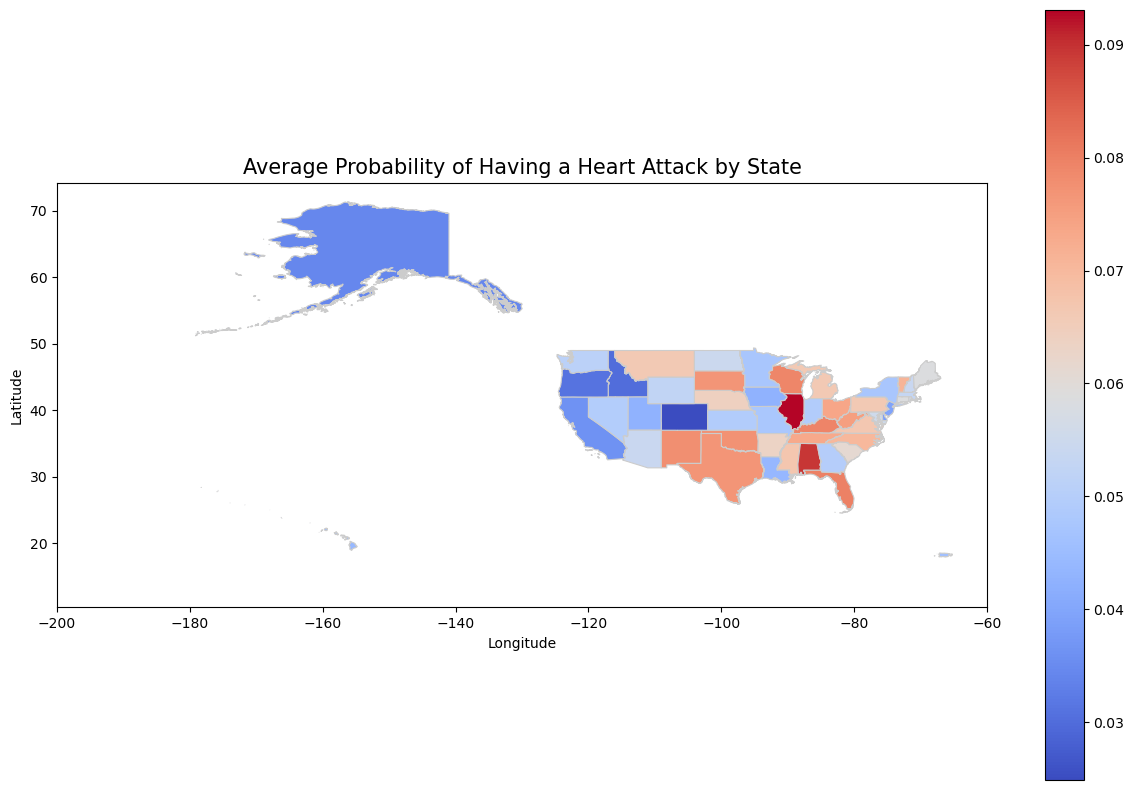

In [273]:
# Step 2: Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_gdf.plot(column='probability', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

# Set limits to focus on the contiguous US (adjust these based on your data's extents)
ax.set_xlim([-200, -60])  # Longitude range (from west to east)
# ax.set_ylim([20, 50])     # Latitude range (from south to north)

# Remove empty space around the plot
# ax.margins(0)

# Customize the plot
plt.title('Average Probability of Having a Heart Attack by State', fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot to a file
plt.savefig('us_heart_attack_probability.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

In [315]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

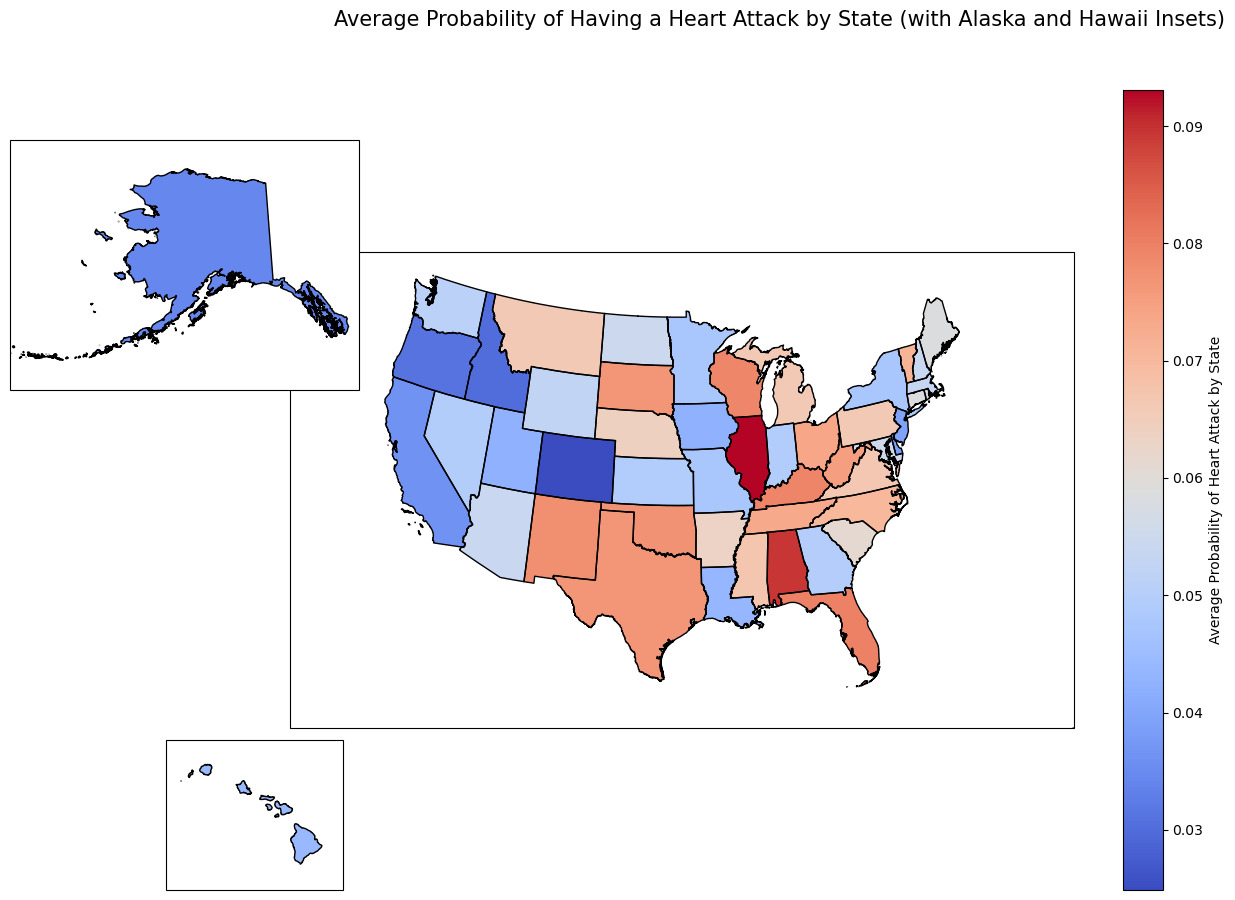

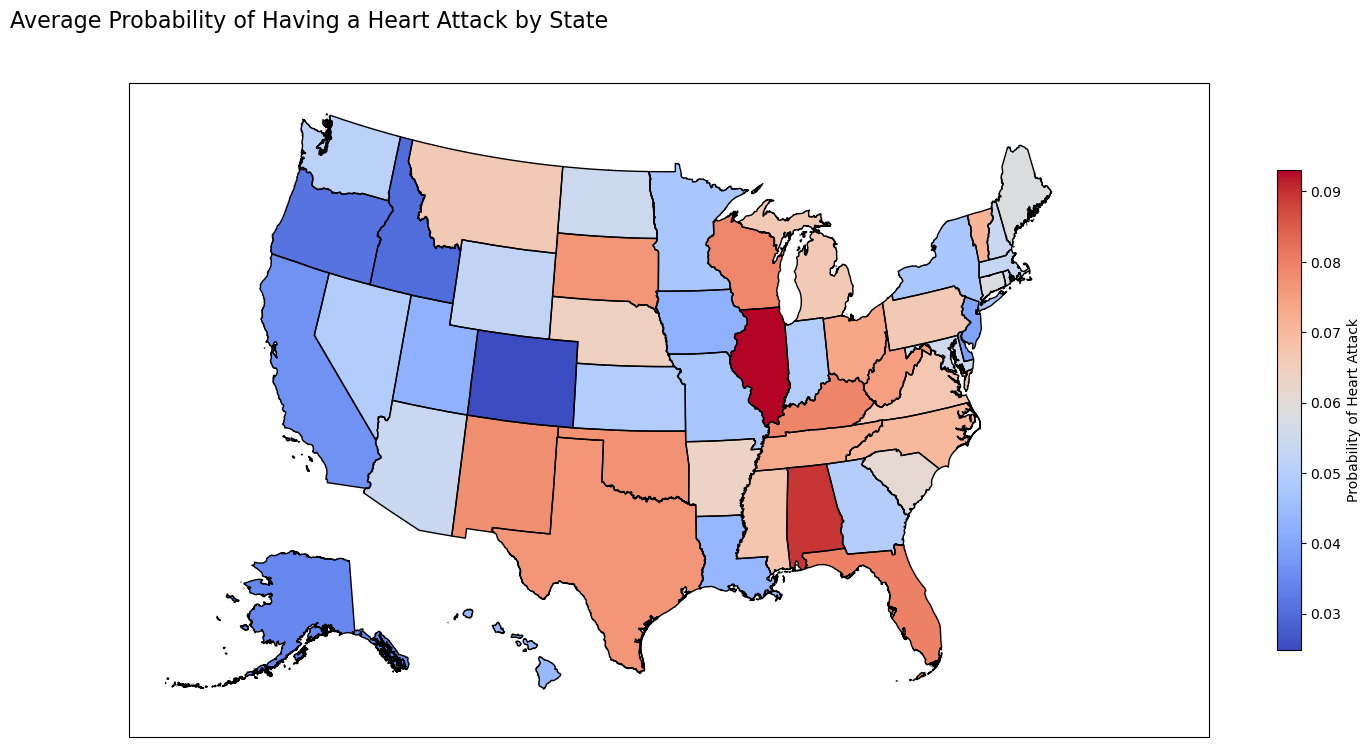

In [362]:
# Load the shapefile with cartopy's reader to use the geometries
shapefile = shpreader.Reader("cb_2018_us_state_500k.shp")

# Create the main plot for the contiguous US
fig = plt.figure(figsize=(18, 10))  # Increase figure width for better spacing
ax = fig.add_axes([0.1, 0.1, 0.75, 0.8], projection=ccrs.LambertConformal())  # Shift plot slightly to the right

# Plot the contiguous US
ax.set_extent([-125, -66.5, 20, 50], crs=ccrs.Geodetic())
ax.add_geometries(shapefile.geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='none')

# Plot the data from merged_gdf
merged_gdf.plot(column='probability', cmap='coolwarm', ax=ax, legend=True, 
                legend_kwds={'label': "Probability of Heart Attack", 'orientation': 'vertical',  'shrink': 0.6},
                transform=ccrs.PlateCarree())

# Add Alaska in an inset axis (top left, scaled down)
ax_inset_ak = fig.add_axes([0.1, 0.2, 0.18, 0.18], projection=ccrs.AlbersEqualArea(central_longitude=-150, central_latitude=60), frame_on=False)
ax_inset_ak.set_extent([-180, -130, 50, 72], ccrs.Geodetic())
ax_inset_ak.add_geometries(shapefile.geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='none')
merged_gdf.plot(column='probability', cmap='coolwarm', ax=ax_inset_ak, transform=ccrs.PlateCarree())

# Add Hawaii in an inset axis (bottom left, scaled down)
ax_inset_hi = fig.add_axes([0.25, 0.2, 0.12, 0.12], projection=ccrs.AlbersEqualArea(central_longitude=-157, central_latitude=20), frame_on=False)
ax_inset_hi.set_extent([-161, -154, 18, 23], ccrs.Geodetic())
ax_inset_hi.add_geometries(shapefile.geometries(), ccrs.PlateCarree(), edgecolor='black', facecolor='none')
merged_gdf.plot(column='probability', cmap='coolwarm', ax=ax_inset_hi, transform=ccrs.PlateCarree())

# Adjust the title position and font size
plt.suptitle('Average Probability of Having a Heart Attack by State', fontsize=16, x = .20, y=0.90)

# Save the plot to a file
plt.savefig('us_heart_attack_probability_final.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()